In [1]:
import numpy as np
from numpy import trapz
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,binned_statistic
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.io import ascii, fits
from astropy import wcs
from pymoc.util.catalog import catalog_to_moc
from scipy.stats import norm,kstest

from astropy.table import Table,vstack,Column,join
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky

import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm
from lifelines import KaplanMeierFitter
from herschelhelp import image_plotting
from herschelhelp_internal.utils import inMoc

In [5]:
help_masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171020.fits')
ldust_pred = Table.read('../../../../../HELP/dmu_products/dmu28/dmu28_ELAIS-N1/data/ELAIS_N1_Ldust_prediction_results.fits')
ldust_pred.rename_column('id','help_id')
joined = join(ldust_pred,help_masterlist,join_type='inner',keys='help_id')

In [6]:
joined[0]

help_id,bayes.dust.luminosity,bayes.dust.luminosity_err,best.reduced_chi_square,best.wfc_u,best.megacam_u,best.suprime_g,best.megacam_g,best.gpc1_g,best.wfc_g,best.suprime_r,best.gpc1_r,best.wfc_r,best.megacam_r,best.gpc1_i,best.suprime_i,best.wfc_i,best.gpc1_z,best.wfc_z,best.megacam_z,best.suprime_z,best.suprime_n921,best.gpc1_y,best.suprime_y,best.ukidss_j,best.ukidss_k,best.irac_i1,best.irac_i2,best.irac_i3,best.irac_i4,best.mips_24,best.pacs_green,best.pacs_red,best.spire_250,best.spire_350,best.spire_500,field,ra,dec,hp_idx,ebv,redshift,zspec,f_wfc_u,ferr_wfc_u,f_ap_wfc_u,ferr_ap_wfc_u,m_wfc_u,merr_wfc_u,m_ap_wfc_u,merr_ap_wfc_u,flag_wfc_u,f_megacam_u,ferr_megacam_u,f_ap_megacam_u,ferr_ap_megacam_u,m_megacam_u,merr_megacam_u,m_ap_megacam_u,merr_ap_megacam_u,flag_megacam_u,f_suprime_g,ferr_suprime_g,f_ap_suprime_g,ferr_ap_suprime_g,m_suprime_g,merr_suprime_g,m_ap_suprime_g,merr_ap_suprime_g,flag_suprime_g,f_megacam_g,ferr_megacam_g,f_ap_megacam_g,ferr_ap_megacam_g,m_megacam_g,merr_megacam_g,m_ap_megacam_g,merr_ap_megacam_g,flag_megacam_g,f_gpc1_g,ferr_gpc1_g,f_ap_gpc1_g,ferr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,flag_gpc1_g,f_wfc_g,ferr_wfc_g,f_ap_wfc_g,ferr_ap_wfc_g,m_wfc_g,merr_wfc_g,m_ap_wfc_g,merr_ap_wfc_g,flag_wfc_g,f_suprime_r,ferr_suprime_r,f_ap_suprime_r,ferr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_r,merr_ap_suprime_r,flag_suprime_r,f_gpc1_r,ferr_gpc1_r,f_ap_gpc1_r,ferr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,flag_gpc1_r,f_wfc_r,ferr_wfc_r,f_ap_wfc_r,ferr_ap_wfc_r,m_wfc_r,merr_wfc_r,m_ap_wfc_r,merr_ap_wfc_r,flag_wfc_r,f_megacam_r,ferr_megacam_r,f_ap_megacam_r,ferr_ap_megacam_r,m_megacam_r,merr_megacam_r,m_ap_megacam_r,merr_ap_megacam_r,flag_megacam_r,f_gpc1_i,ferr_gpc1_i,f_ap_gpc1_i,ferr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,flag_gpc1_i,f_suprime_i,ferr_suprime_i,f_ap_suprime_i,ferr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_i,merr_ap_suprime_i,flag_suprime_i,f_wfc_i,ferr_wfc_i,f_ap_wfc_i,ferr_ap_wfc_i,m_wfc_i,merr_wfc_i,m_ap_wfc_i,merr_ap_wfc_i,flag_wfc_i,f_gpc1_z,ferr_gpc1_z,f_ap_gpc1_z,ferr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,flag_gpc1_z,f_wfc_z,ferr_wfc_z,f_ap_wfc_z,ferr_ap_wfc_z,m_wfc_z,merr_wfc_z,m_ap_wfc_z,merr_ap_wfc_z,flag_wfc_z,f_megacam_z,ferr_megacam_z,f_ap_megacam_z,ferr_ap_megacam_z,m_megacam_z,merr_megacam_z,m_ap_megacam_z,merr_ap_megacam_z,flag_megacam_z,f_suprime_z,ferr_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_suprime_z,merr_ap_suprime_z,flag_suprime_z,f_suprime_n921,ferr_suprime_n921,f_ap_suprime_n921,ferr_ap_suprime_n921,m_suprime_n921,merr_suprime_n921,m_ap_suprime_n921,merr_ap_suprime_n921,flag_suprime_n921,f_gpc1_y,ferr_gpc1_y,f_ap_gpc1_y,ferr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,flag_gpc1_y,f_suprime_y,ferr_suprime_y,f_ap_suprime_y,ferr_ap_suprime_y,m_suprime_y,merr_suprime_y,m_ap_suprime_y,merr_ap_suprime_y,flag_suprime_y,f_ukidss_j,ferr_ukidss_j,f_ap_ukidss_j,ferr_ap_ukidss_j,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,flag_ukidss_j,f_ukidss_k,ferr_ukidss_k,f_ap_ukidss_k,ferr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,m_ap_ukidss_k,merr_ap_ukidss_k,flag_ukidss_k,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,flag_irac_i2,f_irac_i3,ferr_irac_i3,f_ap_irac_i3,ferr_ap_irac_i3,m_irac_i3,merr_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,flag_irac_i3,f_irac_i4,ferr_irac_i4,f_ap_irac_i4,ferr_ap_irac_i4,m_irac_i4,merr_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,flag_irac_i4,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dust

In [10]:
z = joined['redshift']
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_rad_pred = joined['bayes.dust.luminosity']
f_rad_pred = lum_rad_pred/(4*np.pi*dist**2)/1E-26

In [2]:
imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE250_v1.0.fits'
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['image'].header

im250=hdulist['image'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist['image'].header)
hdulist.close()

fname = 'data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0]
hdulist.close()

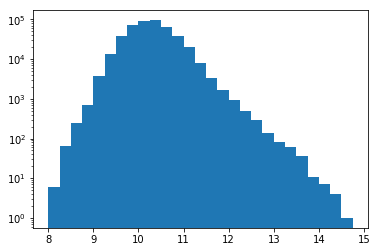

In [13]:
bins = np.arange(8,15,0.25)
y = np.log10(f_rad_pred)
plt.hist(y,bins=bins,log=True)
plt.show()

In [42]:
bins = np.arange(8,15,0.25)
y = np.log10(f_rad_pred)
flux_bins = np.digitize(y,bins)
mean_spire_flux = []
mean_lofar_flux = []
for n in np.unique(flux_bins):
    print(n)
    mask = flux_bins==n
    ras = joined[mask]['ra']
    decs = joined[mask]['dec']
    
    x_pix,y_pix = w_250.wcs_world2pix(ras,decs,0,ra_dec_order=True)
    x_pix = x_pix.astype('int')
    y_pix = y_pix.astype('int')
    spire_flux = im250[y_pix,x_pix]
    mean_spire_flux.append(np.nanmean(spire_flux))
    
    x_pix,y_pix = radim_wcs.wcs_world2pix(ras,decs,0,ra_dec_order=True)
    x_pix = x_pix.astype('int')
    y_pix = y_pix.astype('int')
    spire_flux = radim_data[y_pix,x_pix]
    mean_lofar_flux.append(np.nanmean(spire_flux))
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


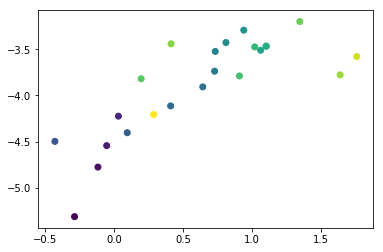

In [47]:
x = np.log10(mean_spire_flux)
y = np.log10(mean_lofar_flux)
plt.scatter(x,y,c=range(0,28))
plt.show()

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


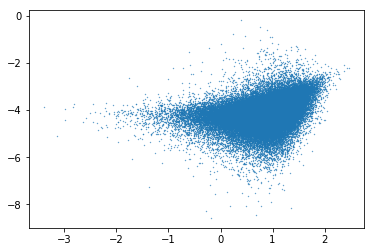

In [50]:
mask = (~np.isnan(help_masterlist['f_spire_250'])) & (~help_masterlist['flag_spire_250'])

ras = help_masterlist[mask]['ra']
decs = help_masterlist[mask]['dec']
    
x_pix,y_pix = w_250.wcs_world2pix(ras,decs,0,ra_dec_order=True)
x_pix = x_pix.astype('int')
y_pix = y_pix.astype('int')
spire_flux = im250[y_pix,x_pix]

x_pix,y_pix = radim_wcs.wcs_world2pix(ras,decs,0,ra_dec_order=True)
x_pix = x_pix.astype('int')
y_pix = y_pix.astype('int')
lofar_flux = radim_data[y_pix,x_pix]

plt.scatter(np.log10(spire_flux),np.log10(lofar_flux),s=0.1)
plt.show()
